In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from arch import arch_model
from statsmodels.tsa.api import VAR

In [57]:
df = pd.read_excel('data.xlsx')
df_r_pbk = df['Date']
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
# df = df.to_numpy()
df

,PBK
Date,
2015-01-01,1209.5
2015-01-02,1203.9
2015-01-05,1210.9
2015-01-06,1221.4
2015-01-07,1220.9
...,...
2022-12-23,1032.6
2022-12-27,1032.7
2022-12-28,1020.2


In [59]:
df_r_pbk = pd.DataFrame(df_r_pbk)
df_r_pbk

,Date
0,2015-01-01
1,2015-01-02
2,2015-01-05
3,2015-01-06
4,2015-01-07
...,...
2019,2022-12-23
2020,2022-12-27
2021,2022-12-28
2022,2022-12-29


In [31]:
data = df[:, 1]
data = np.float16(data)
data

array([1210., 1204., 1211., ..., 1020., 1065., 1083.], dtype=float16)

In [11]:
r_pbk= np.diff(np.log(data), n=1, axis=0)

In [12]:
r_pbk

array([-0.003906,  0.003906,  0.01172 , ..., -0.01563 ,  0.04688 ,
        0.01563 ], dtype=float16)

In [62]:
df_r_pbk['Return'] = pd.DataFrame(r_pbk)
df_r_pbk = df_r_pbk.set_index('Date')
df_r_pbk.index = pd.to_datetime(df_r_pbk.index)

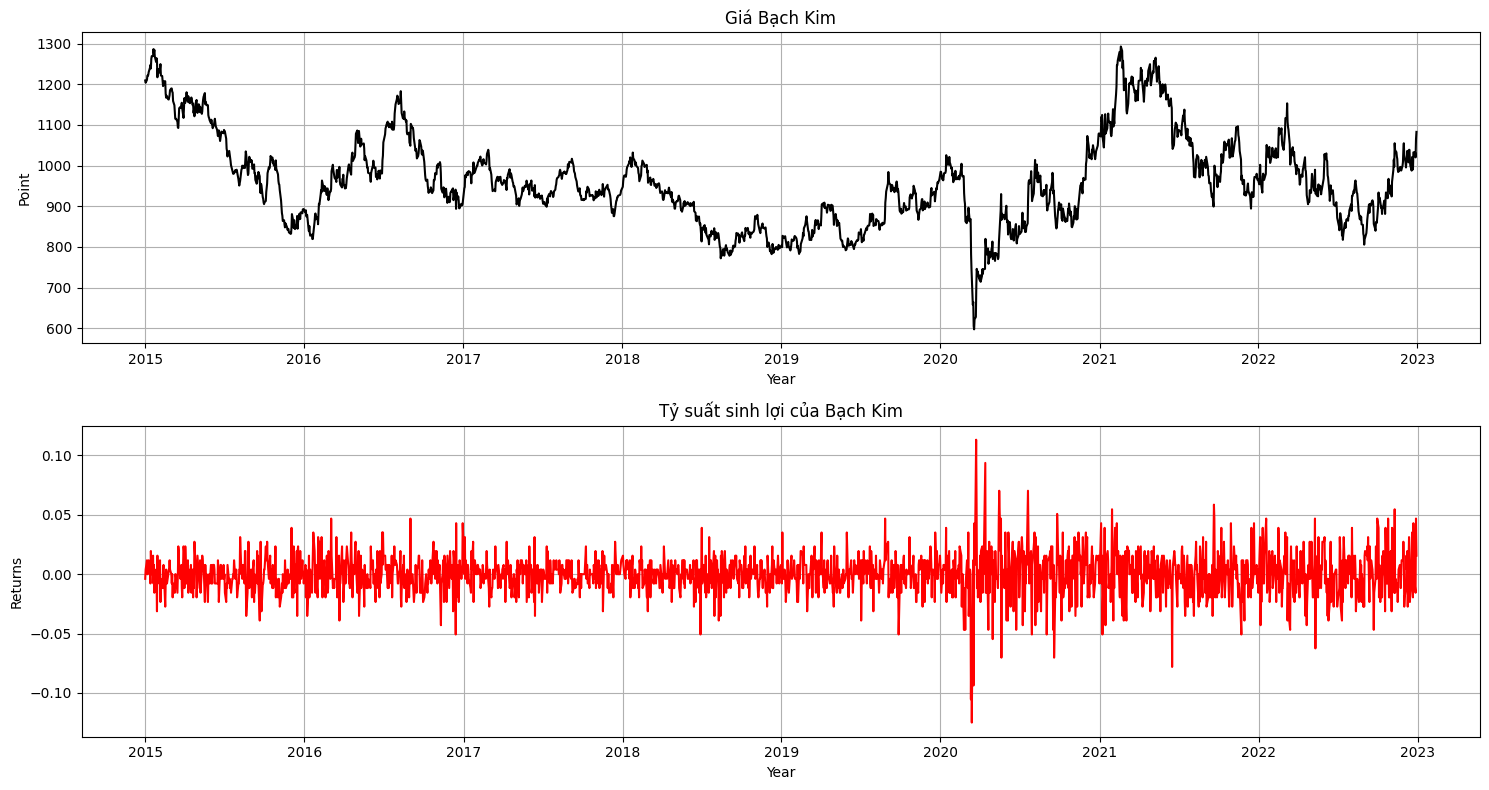

In [63]:
fig, ax= plt.subplots(2,1, figsize=(15,8))
ax[0].plot(df, color='black')
ax[0].title.set_text('Giá Bạch Kim')
ax[0].set(xlabel='Year', ylabel='Point')
ax[0].grid(True)
ax[1].plot(df_r_pbk, color='red')
ax[1].title.set_text('Tỷ suất sinh lợi của Bạch Kim')
ax[1].set(xlabel='Year', ylabel='Returns')
ax[1].grid(True)
plt.tight_layout()

In [16]:
print('Obs       :', len(r_pbk))
print('Median    :', np.median(r_pbk))
print('Mean      :', np.mean(r_pbk))
print('Std. Dev  :', np.std(r_pbk, ddof=1))
print('Minimum   :', np.min(r_pbk))
print('Maximum   :', np.max(r_pbk))
print('Skewness  :', stats.skew(r_pbk))
print('Kurtosis  :', stats.kurtosis(r_pbk, fisher = False))
print('Jarque-Bera test:', stats.jarque_bera(r_pbk))

Obs       : 2023
Median    : 0.0
Mean      : -5.406e-05
Std. Dev  : 0.01726
Minimum   : -0.125
Maximum   : 0.1133
Skewness  : -0.19742266236367312
Kurtosis  : 7.405654174884944
Jarque-Bera test: SignificanceResult(statistic=1649.2247493200246, pvalue=0.0)


c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1074: RuntimeWarning: overflow encountered in divide
  rel_diff = np.max(np.abs(a_zero_mean), axis=axis,


In [17]:
adf= adfuller(r_pbk)
print('ADF Statistic:', adf[0])
print('p-value:', adf[1])
print('Critical Values:', adf[4])

ADF Statistic: -10.795278301824654
p-value: 2.083174844998894e-19
Critical Values: {'1%': -3.433623856429125, '5%': -2.862986213505, '10%': -2.56753990225}


In [65]:
#Chuyển TSSL sang dạng % cho thuận tiện
vn30_scaledreturns= r_pbk

#Ước lượng mô hình ARCH(1)
am0= arch_model(vn30_scaledreturns, mean = 'Zero', p=1, o=0, q=0, dist='normal')
arch1 = am0.fit(update_freq=5, disp = "off")
print("ARCH(1) model:", "\n", arch1.summary(), "\n")
#Kiểm định phần dư của ARCH(1)
arch_stdresid= arch1.resid/arch1.conditional_volatility
arch1lb = acorr_ljungbox(arch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',arch1lb)
jb_arch = jarque_bera(arch_stdresid)
print('\nJB Test Result:','\n',jb_arch)


ARCH(1) model: 
                         Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:                5256.78
Distribution:                  Normal   AIC:                          -10509.6
Method:            Maximum Likelihood   BIC:                          -10498.3
                                        No. Observations:                 2023
Date:                Wed, Jun 12 2024   Df Residuals:                     2023
Time:                        23:34:41   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4876e-04  8.732e-06     17.0

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [66]:
#Ước lượng mô hình GARCH(1,1)
am1 = arch_model(vn30_scaledreturns, mean = 'Zero', vol='ARCH', p=1, o=0, q=1, dist='normal')
garch1_1 = am1.fit(update_freq=5, disp = "off")
print("GARCH(1,1) model:", "\n", garch1_1.summary(), "\n")

#Kiểm định phần dư của GARCH(1,1)
garch_stdresid= garch1_1.resid/garch1_1.conditional_volatility
garch11lb = acorr_ljungbox(garch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',garch11lb)
jb_arch = jarque_bera(garch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

GARCH(1,1) model: 
                         Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:                5372.18
Distribution:                  Normal   AIC:                          -10740.4
Method:            Maximum Likelihood   BIC:                          -10729.1
                                        No. Observations:                 2023
Date:                Wed, Jun 12 2024   Df Residuals:                     2023
Time:                        23:34:57   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5352e-04  1.860e-05     1

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [67]:
#Ước lượng mô hình TGARCH(1,1)
am2 = arch_model(vn30_scaledreturns, mean = 'Zero', vol='GARCH', p=1, o=1, q=1, dist='Normal')
leverage_garch1_1 = am2.fit(update_freq=5, disp = "off")
print("TGARCH(1,1) model:", "\n", leverage_garch1_1.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
tgarch_stdresid= leverage_garch1_1.resid/leverage_garch1_1.conditional_volatility
tgarch11lb = acorr_ljungbox(tgarch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',tgarch11lb)
jb_arch = jarque_bera(tgarch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

TGARCH(1,1) model: 
                      Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                5509.05
Distribution:                  Normal   AIC:                          -11010.1
Method:            Maximum Likelihood   BIC:                          -10987.6
                                        No. Observations:                 2023
Date:                Wed, Jun 12 2024   Df Residuals:                     2023
Time:                        23:35:30   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.9506e-06  2.160e-10  

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [68]:
#Ước lượng mô hình TGARCH(1,1)
am2 = arch_model(vn30_scaledreturns, mean = 'Zero', vol='EGARCH', p=1, o=0, q=1, dist='Normal')
leverage_garch1_1 = am2.fit(update_freq=5, disp = "off")
print("TGARCH(1,1) model:", "\n", leverage_garch1_1.summary(), "\n")

#Kiểm định phần dư của TGARCH(1,1)
tgarch_stdresid= leverage_garch1_1.resid/leverage_garch1_1.conditional_volatility
tgarch11lb = acorr_ljungbox(tgarch_stdresid, lags=[5,10,15,20]) 
print('LB Test Result:','\n',tgarch11lb)
jb_arch = jarque_bera(tgarch_stdresid)
print('\nJB Test Result:','\n',jb_arch)

TGARCH(1,1) model: 
                        Zero Mean - EGARCH Model Results                       
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:                5509.85
Distribution:                  Normal   AIC:                          -11013.7
Method:            Maximum Likelihood   BIC:                          -10996.9
                                        No. Observations:                 2023
Date:                Wed, Jun 12 2024   Df Residuals:                     2023
Time:                        23:39:12   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         -0.0597  3.163e-02     -1.888

c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [21]:
#Tính các giá trị sai số của mô hình ARCH(1)
res= am0.fit(last_obs=1987, update_freq=5, disp='off')
forecasts = res.forecast(horizon=1)
forecast_vals = forecasts.residual_variance.values[-10:]
actual_vals = vn30_scaledreturns[-10:]

rmse_arch1 = np.sqrt(mean_squared_error(actual_vals, forecast_vals))
mae_arch1 = mean_absolute_error(actual_vals, forecast_vals)
mape_arch1 = np.mean(np.abs(forecast_vals - actual_vals)/np.abs(actual_vals))

def tic(forecast, actual):
    sse = np.sum((forecast - actual)**2)  
    sae = np.sum(np.abs(forecast - np.mean(actual)))
    starch = np.sum((actual - np.mean(actual))**2)
    
    return np.sqrt(sse/starch)
tic_arch1 = tic(forecast_vals, actual_vals) 

print('\nRMSE: %0.3f' % rmse_arch1)
print('MAE: %0.3f' % mae_arch1) 
print('MAPE: %0.3f' % mape_arch1)
print('TIC: % 0.3f' % tic_arch1)

#Tính các giá trị sai số của mô hình GARCH(1,1)
res1= am1.fit(last_obs=1987, update_freq=5, disp='off')
forecasts1 = res1.forecast(horizon=1)
forecast_vals1 = forecasts1.residual_variance.values[-10:]

rmse_garch11 = np.sqrt(mean_squared_error(actual_vals, forecast_vals1))
mae_garch11 = mean_absolute_error(actual_vals, forecast_vals1)
mape_garch11 = np.mean(np.abs(forecast_vals1 - actual_vals)/np.abs(actual_vals))

def tic(forecast, actual):
    sse = np.sum((forecast - actual)**2)  
    sae = np.sum(np.abs(forecast - np.mean(actual)))
    starch = np.sum((actual - np.mean(actual))**2)
    
    return np.sqrt(sse/starch)
tic_garch11 = tic(forecast_vals1, actual_vals) 

print('\nRMSE: %0.3f' % rmse_garch11)
print('MAE: %0.3f' % mae_garch11) 
print('MAPE: %0.3f' % mape_garch11)
print('TIC: % 0.3f' % tic_garch11)

#Tính các giá trị sai số của mô hình TGARCH(1,1)
res2= am2.fit(last_obs=1987, update_freq=5, disp='off')
forecasts2 = res2.forecast(horizon=1)
forecast_vals2 = forecasts2.residual_variance.values[-10:]

rmse_tgarch11 = np.sqrt(mean_squared_error(actual_vals, forecast_vals2))
mae_tgarch11 = mean_absolute_error(actual_vals, forecast_vals2)
mape_tgarch11 = np.mean(np.abs(forecast_vals2 - actual_vals)/np.abs(actual_vals))

def tic(forecast, actual):
    sse = np.sum((forecast - actual)**2)  
    sae = np.sum(np.abs(forecast - np.mean(actual)))
    starch = np.sum((actual - np.mean(actual))**2)
    
    return np.sqrt(sse/starch)
tic_tgarch11 = tic(forecast_vals2, actual_vals) 

print('\nRMSE: %0.3f' % rmse_tgarch11)
print('MAE: %0.3f' % mae_tgarch11) 
print('MAPE: %0.3f' % mape_tgarch11)
print('TIC: % 0.3f' % tic_tgarch11)

RMSE_value=[rmse_arch1, rmse_garch11, rmse_tgarch11]
best_RMSEprediction= np.argmin(RMSE_value)
print('\nBest Forecasting Model (Lowest RMSE):', ['ARCH(1)', 'GARCH(1,1)', 'TGARCH(1_1)'][best_RMSEprediction])

MAE_value=[mae_arch1, mae_arch1, mae_tgarch11]
best_MAEprediction= np.argmin(MAE_value)
print('\nBest Forecasting Model (Lowest MAE):', ['ARCH(1)', 'GARCH(1,1)', 'TGARCH(1_1)',][best_MAEprediction])

MAPE_value=[mape_arch1, mape_garch11, mape_tgarch11]
best_MAPEprediction= np.argmin(MAPE_value)
print('\nBest Forecasting Model (Lowest MAPE):', ['ARCH(1)', 'GARCH(1,1)', 'TGARCH(1_1)',][best_MAPEprediction])

TIC_value=[tic_arch1, tic_garch11, tic_tgarch11]
best_TICprediction= np.argmin(TIC_value)
print('\nBest Forecasting Model (Lowest TIC):', ['ARCH(1)', 'GARCH(1,1)', 'TGARCH(1_1)',][best_TICprediction])



RMSE: 0.026
MAE: 0.021
MAPE: inf
TIC:  3.264

RMSE: 0.026
MAE: 0.022
MAPE: inf
TIC:  3.260

RMSE: 0.026
MAE: 0.022
MAPE: inf
TIC:  3.260

Best Forecasting Model (Lowest RMSE): ARCH(1)

Best Forecasting Model (Lowest MAE): ARCH(1)

Best Forecasting Model (Lowest MAPE): ARCH(1)

Best Forecasting Model (Lowest TIC): GARCH(1,1)


c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\HoangLee\AppData\Local\Temp\ipykernel_19140\3699672666.py:9: RuntimeWarning: divide by zero encountered in divide
  mape_arch1 = np.mean(np.abs(forecast_vals - actual_vals)/np.abs(actual_vals))
c:\Users\HoangLee\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002945. Parameter
estimation work better when this val